In [1]:
import sklearn as sk
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time

import scipy

from scipy.optimize import curve_fit


In [2]:
STORED = {}
STORED_NOISED = {}

#used for benchmarking

While there are many queries outlined in this code, 5 are actually used. We performed

AISLE_FREQ_QUERY
DEPARTMENT_FREQ_QUERY 
DEPARTMENT_REORDER_QUERY



In [82]:
def timer(func, b=0):
  start_time_sec = time.time()
  res = func(b=b)
  elapsed_time_sec = time.time() - start_time_sec
  return (res, elapsed_time_sec)

In [4]:
def add_laplace_noise(x, b):
    return x + np.random.laplace(scale=b, size=len(x))

def add_noise_to_col(df, col, b):
  noised_col = add_laplace_noise(df[col], b)
  df["noised_" + col] = noised_col.clip(lower=0)

def add_noise_to_array(array, b):
    return array + np.random.laplace(scale=b, size=array.shape)


In [168]:
try:
    aisles_df = pd.read_csv('aisles.csv')
    departments_df = pd.read_csv('departments.csv')
    order_products_prior_df = pd.read_csv('order_products__prior.csv')
    order_products_train_df = pd.read_csv('order_products__train.csv')
    orders_df = pd.read_csv('orders.csv')
    products_df = pd.read_csv('products.csv')
except:
    print('Files not available.')

In [173]:
# @title Table Info
print("----------------------------------------")
print("Aisles")
print(aisles_df.info())
print()

print("----------------------------------------")
print("Departments")
print(departments_df.info())
print()

print("----------------------------------------")
print("Products")
print(products_df.info())
print()

print("----------------------------------------")
print("Order Products Prior")
print(order_products_prior_df.info())
print()

print("----------------------------------------")
print("Order Products Train")
print(order_products_train_df.info())
print()

print("----------------------------------------")
print("Orders")
print(orders_df.info())
print()

print("----------------------------------------")

----------------------------------------
Aisles
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None

----------------------------------------
Departments
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   department_id   21 non-null     int64  
 1   department      21 non-null     object 
 2   count           21 non-null     float64
 3   relative_freq   21 non-null     float64
 4   reordered_rate  21 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 968.0+ bytes
None

----------------------------------------
Products
<class 'pandas.core.frame.DataFrame'>
RangeInde

In [174]:
# @title Table Heads
print("----------------------------------------")
print("Aisles")
print(aisles_df.head())
print()

print("----------------------------------------")
print("Departments")
print(departments_df.head())
print()

print("----------------------------------------")
print("Products")
print(products_df.head())
print()

print("----------------------------------------")
print("Order Products Prior")
print(order_products_prior_df.head())
print()

print("----------------------------------------")
print("Order Products Train")
print(order_products_train_df.head())
print()

print("----------------------------------------")
print("Orders")
print(orders_df.head(1000))
print()

print("----------------------------------------")

----------------------------------------
Aisles
   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

----------------------------------------
Departments
   department_id department      count  relative_freq  reordered_rate
0              1     frozen  2236432.0       0.068952        0.541885
1              2      other    36291.0       0.001119        0.407980
2              3     bakery  1176787.0       0.036282        0.628141
3              4    produce  9479291.0       0.292260        0.649913
4              5    alcohol   153696.0       0.004739        0.569924

----------------------------------------
Products
   product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                  

In [175]:
#division by 0 occurs, any NaN replaced by 0

def PRODUCT_FREQ_QUERY(b=0):

  print("INSIDE")

  product_counts = np.zeros(shape=(len(products_df)))

  def product_counter(row):

    product_id = row["product_id"]
    product_counts[product_id-1] += 1

  order_products_prior_df.apply(product_counter, axis=1)

  total_products_count = np.sum(product_counts)

  product_percentages = product_counts / total_products_count

  products_df["count"] = product_counts

  products_df["relative_freq"] = product_percentages

  print(b)

  if b != 0:
    add_noise_to_col(products_df, "relative_freq", b)
    products_df["noised_relative_freq"] /= sum(products_df["noised_relative_freq"])
    return (products_df["relative_freq"], products_df["noised_relative_freq"])
  else:
    return products_df["relative_freq"]

# def AISLE_FREQ_QUERY(b=0):

#   aisle_counts = np.zeros(shape=(len(aisles_df)))

#   def other_counter(row):
#       product_count = row["count"]
#       aisle_id = row["aisle_id"]
#       aisle_counts[aisle_id-1] += product_count

#   products_df.apply(other_counter, axis=1)

#   total_products_count = np.sum(aisle_counts)

#   aisle_percentages = aisle_counts / total_products_count

#   aisles_df["count"] = aisle_counts
#   aisles_df["relative_freq"] = aisle_percentages

#   if b != 0:
#     add_noise_to_col(aisles_df, "relative_freq", b)
#     aisles_df["noised_relative_freq"] /= sum(aisles_df["noised_relative_freq"])

def DEPARTMENT_FREQ_QUERY(b=0):

  department_counts = np.zeros(shape=(len(departments_df)))

  def other_counter(row):
      product_count = row["count"]
      department_id = row["department_id"]
      department_counts[department_id-1] += product_count
    
  products_df.apply(other_counter, axis=1)

  total_products_count = np.sum(department_counts)

  department_percentages = department_counts / total_products_count

  departments_df["count"] = department_counts
  departments_df["relative_freq"] = department_percentages

  if b != 0:
    add_noise_to_col(departments_df, "relative_freq", b)
    departments_df["noised_relative_freq"] /= sum(departments_df["noised_relative_freq"])
    return (departments_df["relative_freq"], departments_df["noised_relative_freq"])
  else:
    return departments_df["relative_freq"]

# def PRODUCT_REORDER_QUERY(b=0):

#   product_reordered_counts = np.zeros(shape=(len(products_df)))

#   def product_counter(row):
#     product_id = row["product_id"]
#     product_reordered_counts[product_id-1] += row["reordered"]

#   order_products_prior_df.apply(product_counter, axis=1)

#   products_df["reordered_count"] = product_reordered_counts

#   product_reordered_rates = np.divide(product_reordered_counts, products_df["count"])
#   products_df["reordered_rate"] = product_reordered_rates

#   print(b)

#   if b != 0:
#     add_noise_to_col(products_df, "reordered_rate", b)

# def AISLE_REORDER_QUERY(b=0):

#   aisle_counts = np.zeros(shape=(len(aisles_df)))
#   aisle_reordered_counts = np.zeros(shape=(len(aisles_df)))

#   def other_counter(row):
#       aisle_id = row["aisle_id"]
#       product_reordered_count = row["reordered_count"]
#       aisle_reordered_counts[aisle_id-1] += product_reordered_count

#   products_df.apply(other_counter, axis=1)

#   aisle_reordered_rates = np.divide(aisle_reordered_counts, aisle_counts)
#   aisle_reordered_rates[np.isnan(aisle_reordered_rates)] = 0

#   aisles_df["count"] = aisle_counts
#   aisles_df["reordered_rate"] = aisle_reordered_rates

#   if b != 0:
#     add_noise_to_col(aisles_df, "reordered_rate", b)

def DEPARTMENT_REORDER_QUERY(b=0):

  product_reordered_counts = np.zeros(shape=(len(products_df)))

  def product_counter(row):
    product_id = row["product_id"]
    product_reordered_counts[product_id-1] += row["reordered"]

  order_products_prior_df.apply(product_counter, axis=1)

  products_df["reordered_count"] = product_reordered_counts

  product_reordered_rates = np.divide(product_reordered_counts, products_df["count"])
  products_df["reordered_rate"] = product_reordered_rates

  print(b)

  if b != 0:
    add_noise_to_col(products_df, "reordered_rate", b)


  department_counts = np.zeros(shape=(len(departments_df)))
  department_reordered_counts = np.zeros(shape=(len(departments_df)))

  def other_counter(row):
      department_id = row["department_id"]
      product_reordered_count = row["reordered_count"]
      product_count = row["count"]
      department_counts[department_id-1] += product_count
      department_reordered_counts[department_id-1] += product_reordered_count

  products_df.apply(other_counter, axis=1)
    
  department_reordered_rates = np.divide(department_reordered_counts, department_counts)
  department_reordered_rates[np.isnan(department_reordered_rates)] = 0

  departments_df["count"] = department_counts
  departments_df["reordered_rate"] = department_reordered_rates

  print("HEY")

  if b != 0:
    add_noise_to_col(departments_df, "reordered_rate", b)
    return (products_df["reordered_rate"], products_df["noised_reordered_rate"])
  else:
    return products_df["reordered_rate"]


In [172]:
PRODUCT_FREQ_QUERY()
DEPARTMENT_FREQ_QUERY()
DEPARTMENT_REORDER_QUERY()

INSIDE
0
0
HEY


0        0.613391
1        0.133333
2        0.732852
3        0.446809
4        0.600000
           ...   
49683    0.111111
49684    0.122449
49685    0.700000
49686    0.461538
49687    0.168539
Name: reordered_rate, Length: 49688, dtype: float64

In [38]:
def epsilon(var, sen):
  return (var / (2 * sen)) ** -2

In [203]:
var_rel_freq_departments = 0.05

sen_rel_freq_departments = 1/(len(departments_df))

e_rel_freq_departments = epsilon(var_rel_freq_departments, sen_rel_freq_departments)

b_rel_freq_departments = sen_rel_freq_departments/e_rel_freq_departments

print(e_rel_freq_departments, b_rel_freq_departments)

3.6281179138321993 0.013125


In [176]:
top_reordered_df = departments_df.sort_values(by=['reordered_rate'], ascending=False)
i = top_reordered_df["count"].idxmin()

var_reorder_rate_departments = 0.001

sen_reorder_rate_departments = 1/(top_reordered_df["count"][i])

e_reorder_rate_departments = epsilon(var_reorder_rate_departments, sen_reorder_rate_departments)

b_reorder_rate_departments = sen_reorder_rate_departments/e_reorder_rate_departments

print(e_reorder_rate_departments, b_reorder_rate_departments)

0.003346461700583707 0.00864325


In [177]:
var_time_count = 10

sen_time_count = 1

e_time_count = epsilon(var_time_count, sen_time_count)

b_time_count = sen_time_count / e_time_count


print(e_time_count, b_time_count)


0.04 25.0


In [178]:
var_bins = 1

sen_bins = 1

e_bins = epsilon(var_bins, sen_bins)

b_bins = sen_bins / e_bins

print(e_bins, b_bins)

4.0 0.25


In [179]:
def min_top_products_by_department(department_name, quantity):

  id = departments_df[departments_df["department"] == department_name]["department_id"].iloc[0]

  df = products_df.query(f"department_id == {id}").sort_values(by=["relative_freq"], ascending=False).head(quantity)

  return min(df["count"])

min1 = min_top_products_by_department("dairy eggs", 10)
min2 = min_top_products_by_department("beverages", 10)
min3 = min_top_products_by_department("produce", 10)

m_freq_shown = min([min1, min2, min3])

var_rel_freq_products = 0.0001

sen_rel_freq_products = 1/m_freq_shown

e_rel_freq_products = epsilon(var_rel_freq_products, sen_rel_freq_products)

b_rel_freq_products = var_rel_freq_products / e_rel_freq_products

print(e_rel_freq_products, b_rel_freq_products)


0.6442191468359747 0.000155226681


In [180]:
PRODUCT_FREQ_QUERY(b_rel_freq_products)
DEPARTMENT_FREQ_QUERY(b_rel_freq_departments)
DEPARTMENT_REORDER_QUERY(b_rel_freq_departments)






INSIDE
0.000155226681
0.013125
HEY


(0        0.613391
 1        0.133333
 2        0.732852
 3        0.446809
 4        0.600000
            ...   
 49683    0.111111
 49684    0.122449
 49685    0.700000
 49686    0.461538
 49687    0.168539
 Name: reordered_rate, Length: 49688, dtype: float64,
 0        0.631691
 1        0.129524
 2        0.715521
 3        0.442994
 4        0.626368
            ...   
 49683    0.077767
 49684    0.129046
 49685    0.685543
 49686    0.457323
 49687    0.166482
 Name: noised_reordered_rate, Length: 49688, dtype: float64)

In [181]:
departments_df.sort_values(by=["relative_freq"], ascending=False).head()

,department_id,department,count,relative_freq,reordered_rate,noised_relative_freq,noised_reordered_rate
3,4,produce,9479291.0,0.292260,0.649913,0.266521,0.649827
15,16,dairy eggs,5414016.0,0.166922,0.669969,0.156676,0.656752
18,19,snacks,2887550.0,0.089027,0.574180,0.060270,0.571980
6,7,beverages,2690129.0,0.082940,0.653460,0.088132,0.688547
0,1,frozen,2236432.0,0.068952,0.541885,0.035366,0.549029


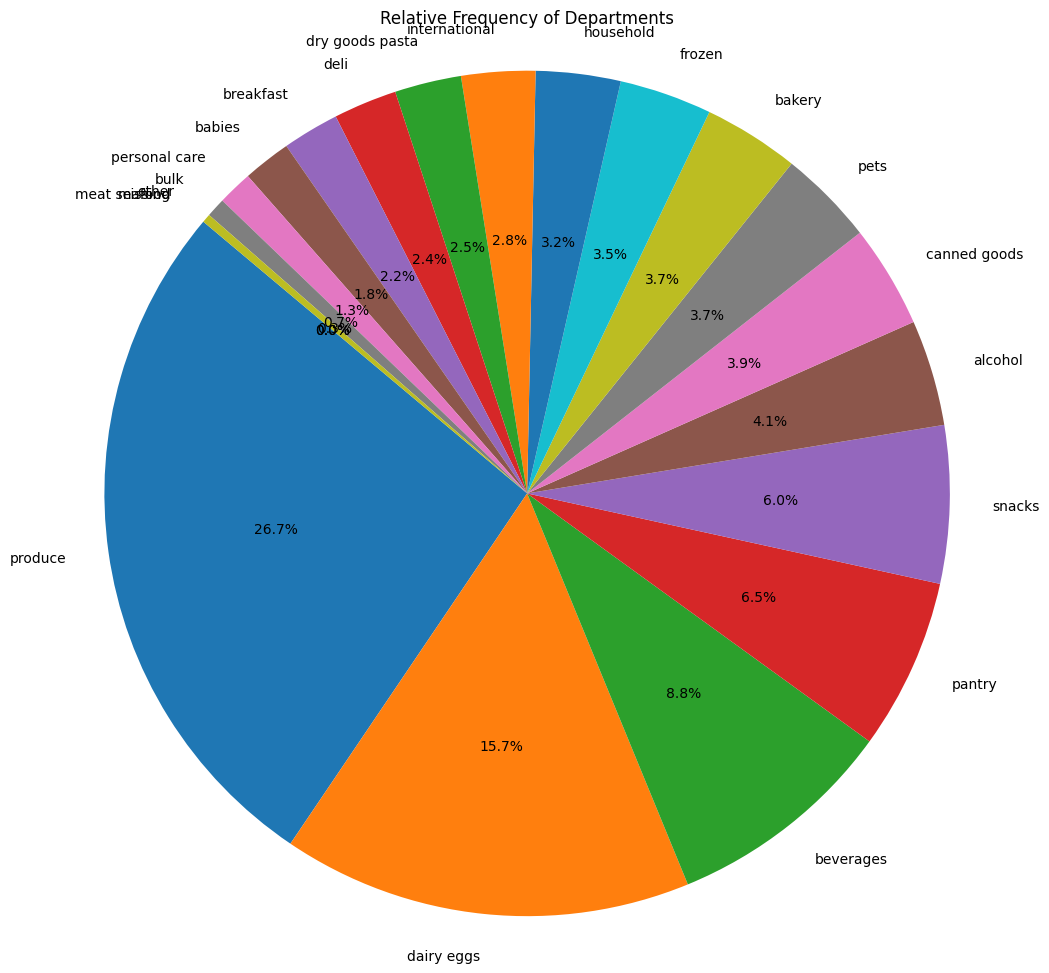

In [182]:
df = departments_df.sort_values(by=["noised_relative_freq"], ascending=False)

plt.figure(figsize=(12, 12))  # Optional: Adjust the figure size
plt.pie(df['noised_relative_freq'], labels=df['department'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title
plt.title('Relative Frequency of Departments')

# Show plot
plt.show()

Text(0.5, 1.0, 'Highest Reorder Rate of Departments')

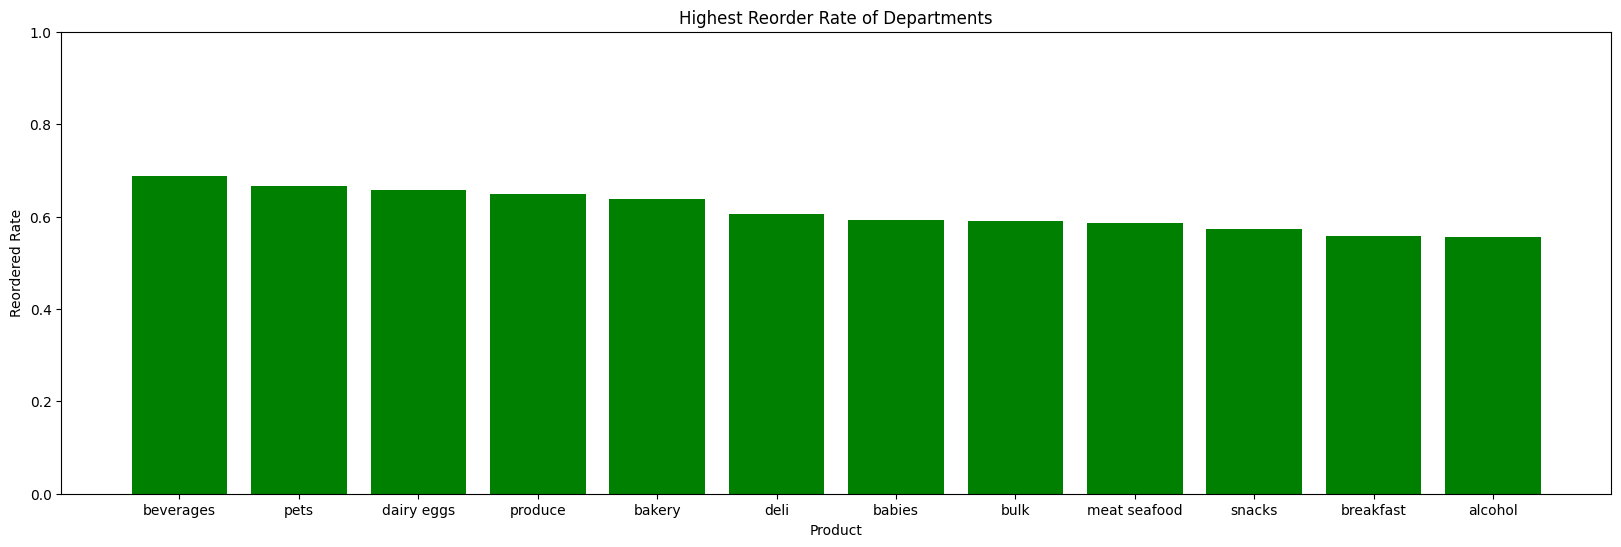

In [183]:
df = departments_df.sort_values(by=['noised_reordered_rate'], ascending=False).head(12)

plt.figure(figsize=(20, 6))  # Optional: Adjust the figure size
plt.bar(df['department'], df['noised_reordered_rate'], color='green')

plt.ylim(0, 1)

# Adding labels and title
plt.xlabel('Product')
plt.ylabel('Reordered Rate')
plt.title('Highest Reorder Rate of Departments')

# Show plot

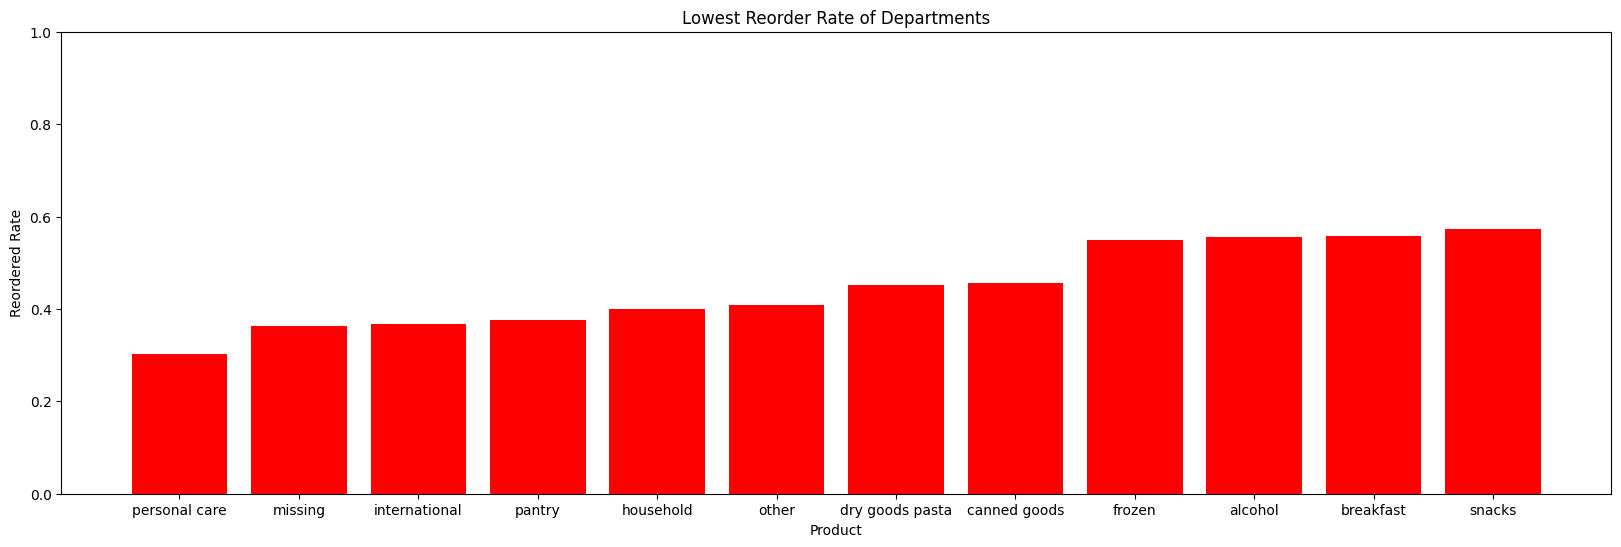

In [184]:
df = departments_df.sort_values(by=['noised_reordered_rate'], ascending=True).head(12)

plt.figure(figsize=(20, 6))  # Optional: Adjust the figure size
plt.bar(df['department'], df['noised_reordered_rate'], color='red')

plt.ylim(0, 1)

# Adding labels and title
plt.xlabel('Product')
plt.ylabel('Reordered Rate')
plt.title('Lowest Reorder Rate of Departments')

# Show plot
plt.show()



In [185]:

def time_heatmap(order_subset, b):

  products_heatmap = None
  noised_products_heatmap = None

  time_table = np.zeros(shape=(7, 24))

  def counter(row):
    time_table[row["order_dow"], row["order_hour_of_day"]] += 1

  order_subset.apply(counter, axis=1)

  products_heatmap = np.copy(time_table)

  time_table = add_noise_to_array(time_table, b)

  noised_products_heatmap = np.copy(time_table)

  plt.figure(figsize=(8, 6))
  heatmap = plt.imshow(time_table, cmap='hot', interpolation='nearest')
  plt.title("Product Heatmap by Time")

  plt.colorbar(heatmap)
  plt.xlabel('Hour of the Day')
  plt.ylabel('Day of the Week (starting Sunday)')

  plt.show()

  if b != 0:
    return (products_heatmap, noised_products_heatmap)
  else:
    return (products_heatmap)

  

 

# def time_heatmap_product(product_name, b):

#   try:

#     id = products_df[products_df["product_name"] == product_name]["product_id"].iloc[0]

#     df1 = order_products_prior_df[order_products_prior_df['product_id'] == id]
#     df2 = df1.drop_duplicates(subset=["order_id"])
#     df3 = pd.merge(df2, orders_df, on="order_id", how="inner")

#     time_heatmap(df3, b)

#   except:
#     print("Product does not exist.")

# def time_heatmap_approximate_product(product_name, b, aisle_name=None, department_name=None):




#     possible_product_ids_rows = products_df[products_df["product_name"].str.contains(product_name, case=False)]

#     if aisle_name:
#       aisle_id = aisles_df[aisles_df["aisle"] == aisle_name]["aisle_id"].iloc[0]
#       possible_product_ids_rows = possible_product_ids_rows.query(f"aisle_id == {aisle_id}")

#     if department_name:
#       department_id = departments_df[departments_df["department"] == department_name]["department_id"].iloc[0]
#       possible_product_ids_rows = possible_product_ids_rows.query(f"department_id == {department_id}")

#     possible_product_ids = possible_product_ids_rows["product_id"]


#     display(possible_product_ids)

#     df1 = order_products_prior_df[order_products_prior_df["product_id"].isin(possible_product_ids)]
#     df2 = df1.drop_duplicates(subset=["order_id"])
#     df3 = pd.merge(df2, orders_df, on="order_id", how="inner")

#     time_heatmap(df3, b)






# def time_heatmap_aisle(aisle_name, b):

#   try:

#     id = aisles_df[aisles_df["aisle"] == aisle_name]["aisle_id"].iloc[0]

#     possible_product_ids = products_df.query(f"aisle_id == {id}")["product_id"]

#     df1 = order_products_prior_df[order_products_prior_df['product_id'].isin(possible_product_ids)]
#     df2 = df1.drop_duplicates(subset=["order_id"])
#     df3 = pd.merge(df2, orders_df, on="order_id", how="inner")

#     time_heatmap(df3, b)

#   except:
#     print("Aisle does not exist.")

# def time_heatmap_department(department_name, b):

#   try:

#     id = departments_df[departments_df["department"] == department_name]["department_id"].iloc[0]

#     possible_product_ids = products_df.query(f"department_id == {id}")["product_id"]

#     df1 = order_products_prior_df[order_products_prior_df['product_id'].isin(possible_product_ids)]
#     df2 = df1.drop_duplicates(subset=["order_id"])
#     df3 = pd.merge(df2, orders_df, on="order_id", how="inner")

#     time_heatmap(df3, b)

#   except:
#     print("Department does not exist.")

def time_heatmap_all(b):

  df1 = order_products_prior_df
  df2 = df1.drop_duplicates(subset=["order_id"])
  df3 = pd.merge(df2, orders_df, on="order_id", how="inner")

  return time_heatmap(df3, b)





In [186]:
products_df[products_df["product_name"] == "Banana"]["product_id"].iloc[0]

24852

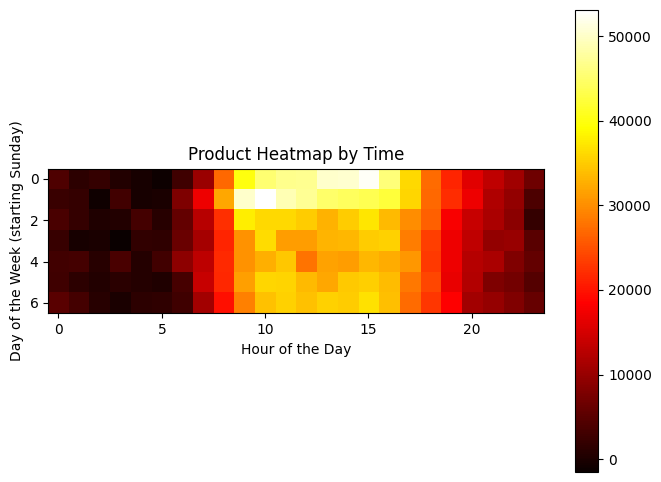

(array([[ 3692.,  2235.,  1299.,   888.,   750.,  1076.,  3138., 11530.,
        26223., 37990., 44999., 47357., 47729., 49997., 50484., 50020.,
        45930., 36874., 27347., 20972., 16984., 13425., 10440.,  6393.],
       [ 3475.,  1735.,  1063.,   711.,   761.,  1523.,  5101., 15792.,
        32563., 49533., 52999., 49008., 44550., 44235., 44220., 43913.,
        42200., 34610., 27293., 20926., 15422., 11292.,  8458.,  5322.],
       [ 2906.,  1485.,   892.,   679.,   700.,  1330.,  4524., 12550.,
        23488., 34499., 37258., 36186., 33752., 34646., 35102., 35408.,
        35482., 30216., 24886., 18922., 14223., 10071.,  7671.,  5079.],
       [ 2767.,  1407.,   889.,   605.,   666.,  1265.,  4314., 11739.,
        21305., 30653., 34016., 33275., 31580., 32194., 32863., 33909.,
        33284., 28619., 23536., 18105., 13064.,  9718.,  7732.,  4895.],
       [ 2476.,  1414.,   837.,   640.,   694.,  1251.,  4135., 11823.,
        20597., 29645., 33056., 31849., 30337., 30778., 316

In [202]:
def HEATMAP_ALL_QUERY(b=0):
    return time_heatmap_all(b)

print(HEATMAP_ALL_QUERY(b=b_time_count))


In [188]:
# def HEATMAP_COFFEE_QUERY(b=0):
#     time_heatmap_approximate_product("Coffee", b)

In [189]:
def top_products_by_department(department_name, quantity):

  id = departments_df[departments_df["department"] == department_name]["department_id"].iloc[0]

  df = products_df.query(f"department_id == {id}").sort_values(by=["noised_relative_freq"], ascending=False).head(quantity)

  plt.figure(figsize=(20, 6))  # Optional: Adjust the figure size
  plt.bar(df['product_name'], df["noised_relative_freq"], color='blue')


  # Adding labels and title
  plt.xlabel('Product')
  plt.ylabel('Relative Frequency')
  plt.title(f'Most Bought Products in {department_name}')

  plt.xticks(fontsize=8)


In [190]:
def min_top_products_by_department(department_name, quantity):

  id = departments_df[departments_df["department"] == department_name]["department_id"].iloc[0]

  df = products_df.query(f"department_id == {id}").sort_values(by=["relative_freq"], ascending=False).head(quantity)

  return df

min_top_products_by_department("produce", 10)

,product_id,product_name,aisle_id,department_id,count,relative_freq,reordered_count,reordered_rate,noised_relative_freq,noised_reordered_rate
24851,24852,Banana,24,4,472565.0,0.014570,398609.0,0.843501,0.003241,0.860896
13175,13176,Bag of Organic Bananas,24,4,379450.0,0.011699,315913.0,0.832555,0.002560,0.832167
21136,21137,Organic Strawberries,24,4,264683.0,0.008161,205845.0,0.777704,0.001799,0.775371
21902,21903,Organic Baby Spinach,123,4,241921.0,0.007459,186884.0,0.772500,0.001642,0.759222
47208,47209,Organic Hass Avocado,24,4,213584.0,0.006585,170131.0,0.796553,0.001485,0.821314
47765,47766,Organic Avocado,24,4,176815.0,0.005451,134044.0,0.758103,0.001179,0.769226
47625,47626,Large Lemon,24,4,152657.0,0.004707,106255.0,0.696038,0.000888,0.655238
16796,16797,Strawberries,24,4,142951.0,0.004407,99802.0,0.698155,0.000994,0.676929
26208,26209,Limes,24,4,140627.0,0.004336,95768.0,0.681007,0.000948,0.739786
27965,27966,Organic Raspberries,123,4,137057.0,0.004226,105409.0,0.769089,0.000925,0.810046


In [191]:

dep = list(departments_df.sort_values(by=['noised_reordered_rate'], ascending=False).head(5)["department"])


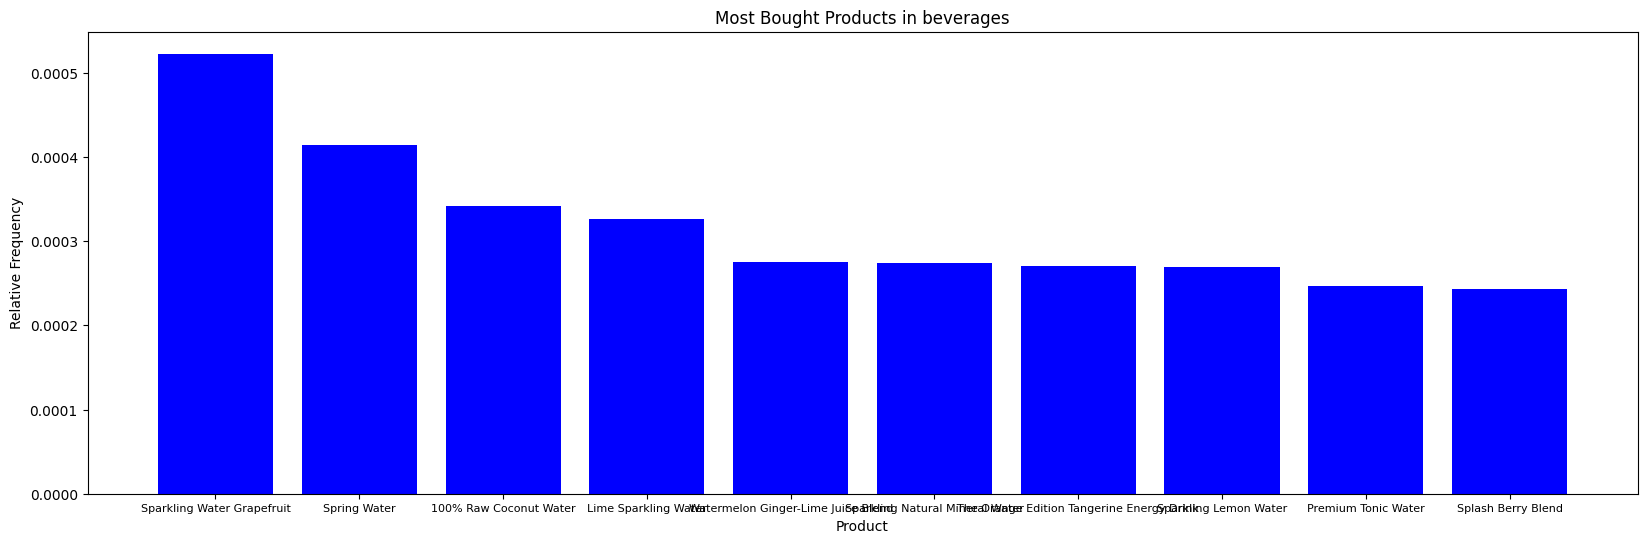

In [192]:
top_products_by_department(dep[0], 10)

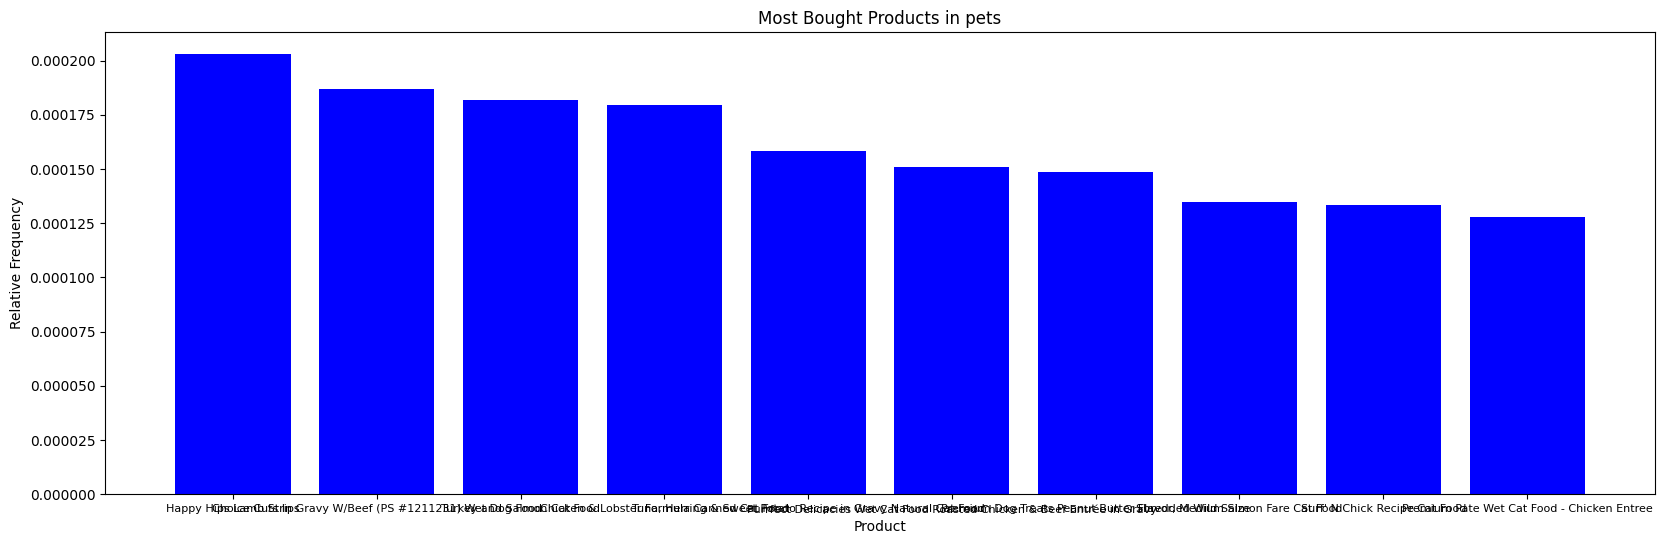

In [193]:
top_products_by_department(dep[1], 10)

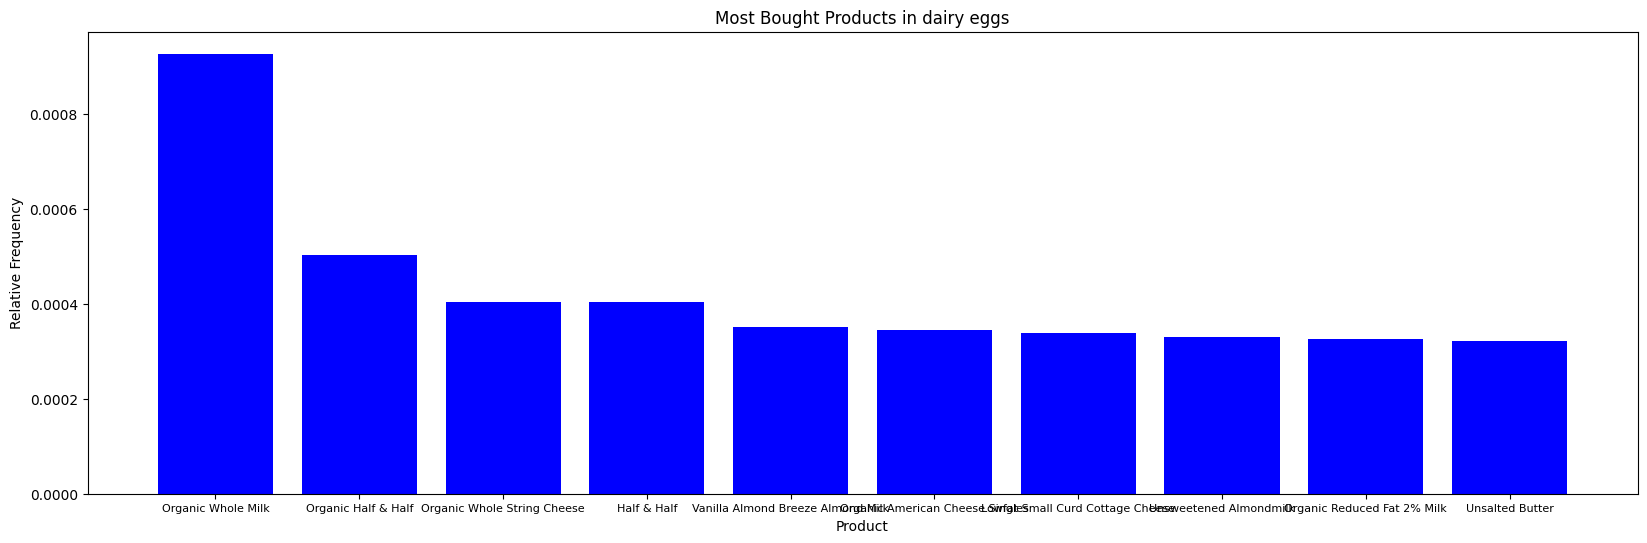

In [194]:
top_products_by_department(dep[2], 10)

In [195]:
def BASKET_SIZE_QUERY(b=0):
    basket_sizes = None
    noised_basket_sizes = None

    basket_sizes = order_products_prior_df['order_id'].value_counts()
    
    if b != 0:
        noised_basket_sizes = add_noise_to_array(basket_sizes, b)
        return (basket_sizes, noised_basket_sizes)
    else:
        return basket_sizes



Text(0.5, 1.0, 'Basket size')

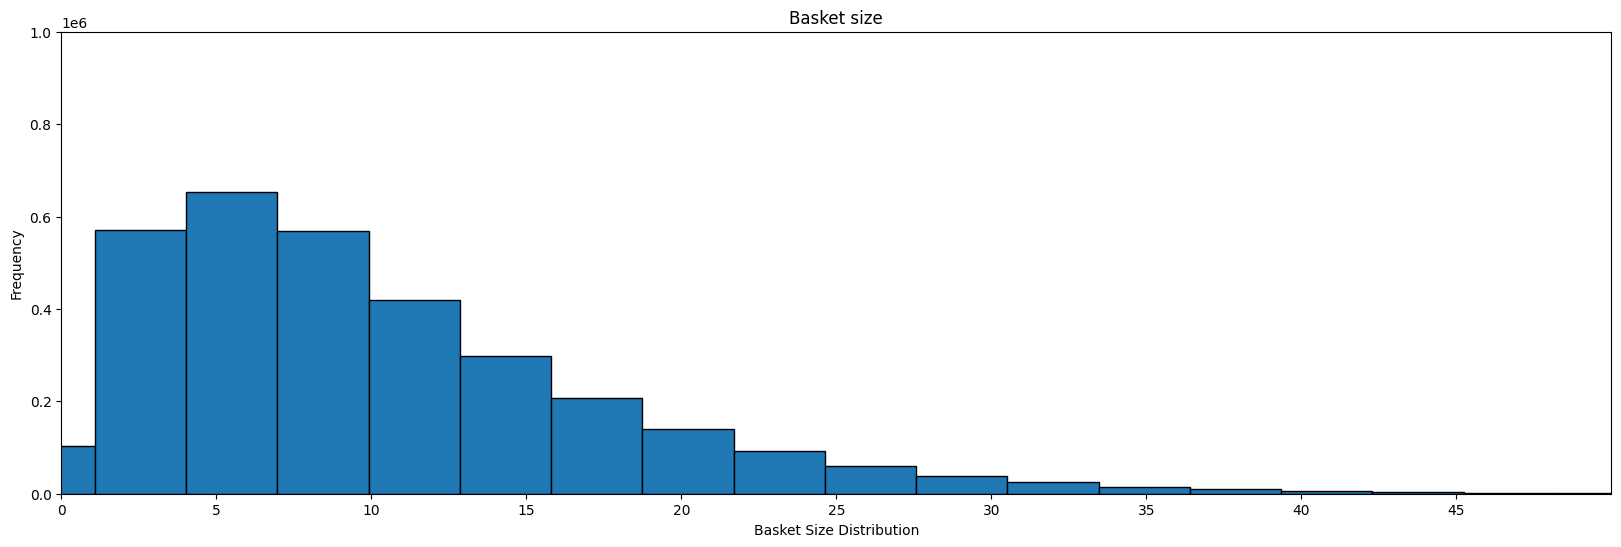

In [199]:
plt.figure(figsize=(20, 6))  # Optional: Adjust the figure size


noised_basket_sizes = BASKET_SIZE_QUERY(b=b_bins)[1]
plt.hist(noised_basket_sizes, bins=50, edgecolor='black')

plt.ylim(0, 1000000)
plt.xlim(0, 50)

plt.xticks(np.arange(0, 50, 5))



# Adding labels and title
plt.xlabel('Basket Size Distribution')
plt.ylabel('Frequency')
plt.title('Basket size')

In [197]:
np.median(noised_basket_sizes)

8.190501833285989

In [198]:
np.average(noised_basket_sizes)

10.088842655768383

In [156]:
QUERIES = [
    PRODUCT_FREQ_QUERY,
    DEPARTMENT_FREQ_QUERY,
    DEPARTMENT_REORDER_QUERY,
    HEATMAP_ALL_QUERY,
    BASKET_SIZE_QUERY
]

SEN = [
    sen_rel_freq_products,
    sen_rel_freq_departments,
    sen_reorder_rate_departments,
    sen_time_count,
    sen_bins
]






INSIDE
0.0009487666034155598
INSIDE
0.0009487666034155598
INSIDE
0.0009487666034155598
INSIDE
0.0009487666034155598
INSIDE
0.0009487666034155598
INSIDE
0.0009487666034155598
INSIDE
0.0009487666034155598
INSIDE
0.0009487666034155598
INSIDE
0.0009487666034155598
INSIDE
0.0009487666034155598
INSIDE
0.00023719165085388995
INSIDE
0.00023719165085388995
INSIDE
0.00023719165085388995
INSIDE
0.00023719165085388995
INSIDE
0.00023719165085388995
INSIDE
0.00023719165085388995
INSIDE
0.00023719165085388995
INSIDE
0.00023719165085388995
INSIDE
0.00023719165085388995
INSIDE
0.00023719165085388995
INSIDE
0.00013553808620222284
INSIDE
0.00013553808620222284
INSIDE
0.00013553808620222284
INSIDE
0.00013553808620222284
INSIDE
0.00013553808620222284
INSIDE
0.00013553808620222284
INSIDE
0.00013553808620222284
INSIDE
0.00013553808620222284
INSIDE
0.00013553808620222284
INSIDE
0.00013553808620222284


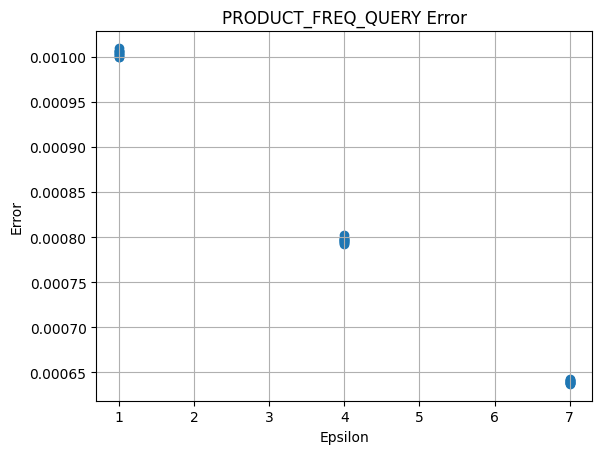

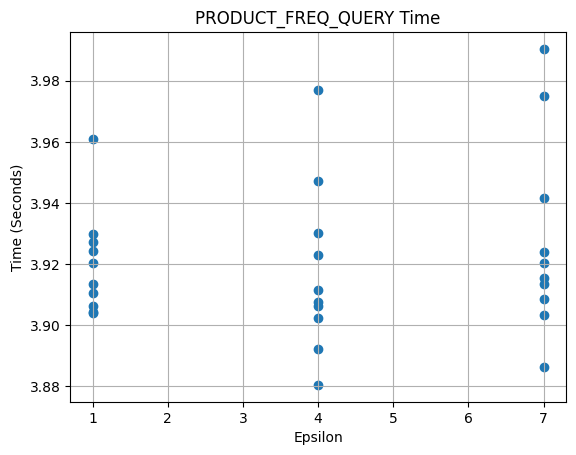

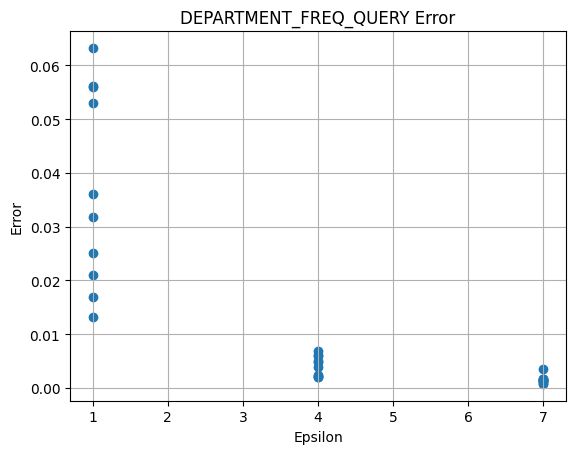

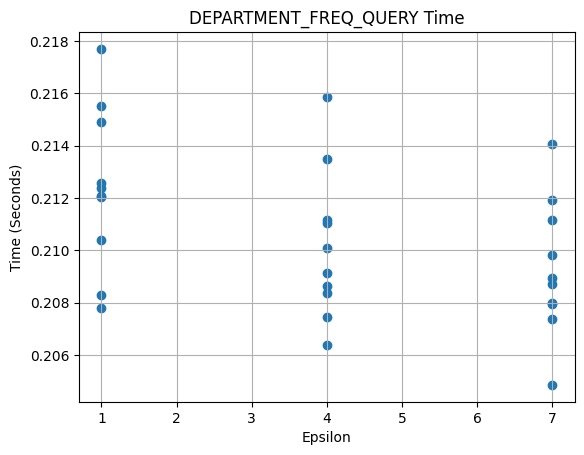

0.0007358351729212656
HEY
0.0007358351729212656
HEY
0.0007358351729212656
HEY
0.0007358351729212656
HEY
0.0007358351729212656
HEY
0.0007358351729212656
HEY
0.0007358351729212656
HEY
0.0007358351729212656
HEY
0.0007358351729212656
HEY
0.0007358351729212656
HEY
0.0001839587932303164
HEY
0.0001839587932303164
HEY
0.0001839587932303164
HEY
0.0001839587932303164
HEY
0.0001839587932303164
HEY
0.0001839587932303164
HEY
0.0001839587932303164
HEY
0.0001839587932303164
HEY
0.0001839587932303164
HEY
0.0001839587932303164
HEY
0.00010511931041732366
HEY
0.00010511931041732366
HEY
0.00010511931041732366
HEY
0.00010511931041732366
HEY
0.00010511931041732366
HEY
0.00010511931041732366
HEY
0.00010511931041732366
HEY
0.00010511931041732366
HEY
0.00010511931041732366
HEY
0.00010511931041732366
HEY


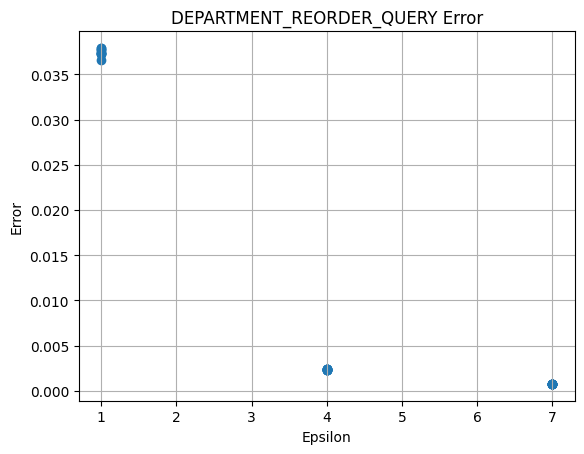

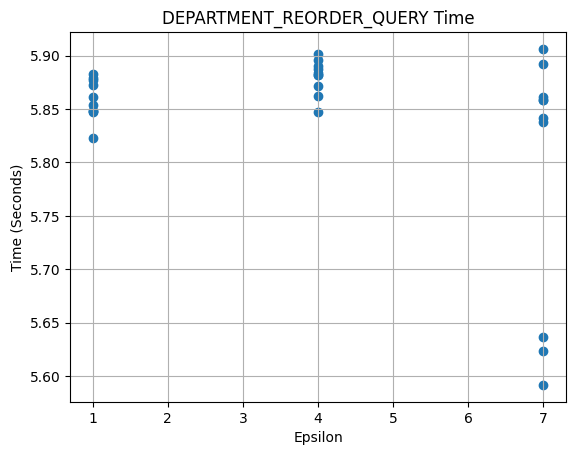

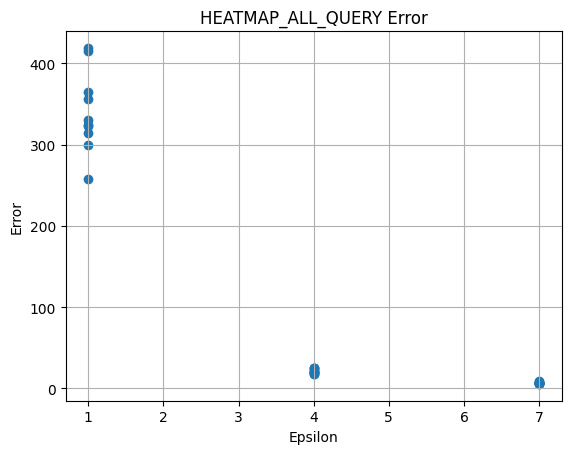

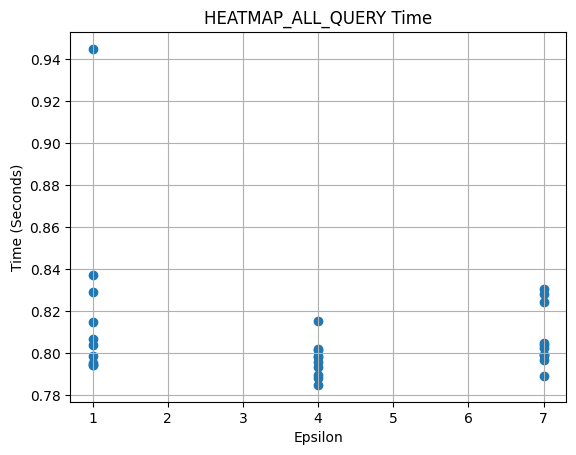

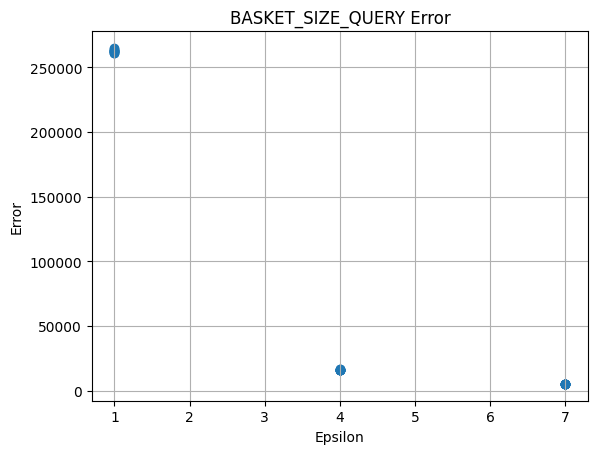

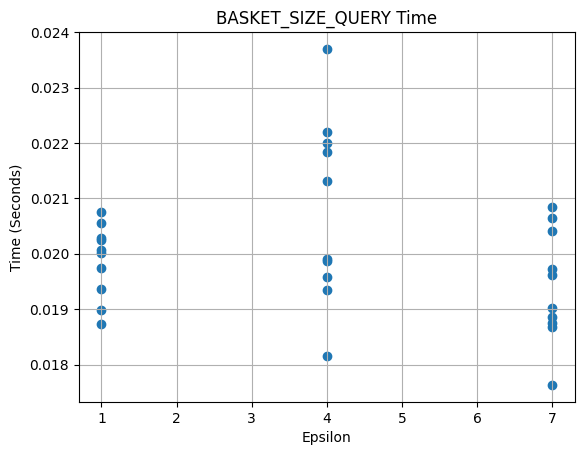

In [161]:
def plot(i):

    name = QUERIES[i].__name__

    inputs = []
    outputs_err = []
    outputs_time = []

    for e in range(1, 8, 3):

        b = SEN[i]/e
        
        for trial in range(10):

            res, time = timer(QUERIES[i], b)
        
            plain, noised = res
            err = np.sum((plain - noised) ** 2)

            inputs.append(e)
            outputs_err.append(err)
            outputs_time.append(time)

    plt.scatter(inputs, outputs_err)

    plt.xlabel('Epsilon')
    plt.ylabel('Error')
    plt.title(f'{QUERIES[i].__name__} Error')

    # Display the plot
    plt.grid(True)
    plt.show()

    plt.scatter(inputs, outputs_time)

    plt.xlabel('Epsilon')
    plt.ylabel('Time (Seconds)')
    plt.title(f'{QUERIES[i].__name__} Time')

    # Display the plot
    plt.grid(True)
    plt.show()

    
for i in range(5):
    plot(i)




    